In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.8MB/s 
     |████████████████████████████████| 9.5MB 25.7MB/s 
     |████████████████████████████████| 2.1MB 46.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [3]:
# Import required packages, libraries and classes for the project
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import datetime as dt
import time
from statsmodels.tsa.arima_model import ARIMAResults
plt.style.use('default')

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockCATT.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-25,246.0,246.0,238.0,1850.0,216.190476,219.641297,34.0,67.266588,17.821782,9.627825,216.6,8.282992e+05,80.952381,85.807656,238.0
2014-06-26,228.0,238.0,228.0,21110.0,214.476190,217.805426,28.0,66.497705,13.461538,9.214435,215.1,9.957417e+05,94.117647,92.156863,236.0
2014-06-30,234.0,234.0,232.0,1500.0,213.142857,215.985969,22.0,64.928560,12.621359,8.756407,213.4,1.147855e+06,82.352941,92.156863,232.0
2014-07-02,224.0,238.0,224.0,17000.0,211.904762,214.384566,34.0,69.584450,14.423077,8.451703,212.2,1.319687e+06,100.000000,98.039216,238.0
2014-07-03,228.0,228.0,228.0,25000.0,210.476190,212.023022,22.0,65.677831,9.615385,7.328948,210.6,1.019886e+06,94.117647,89.705882,228.0


In [5]:
# Extracting the features for the SARIMAX model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.tail()

(1053, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-03,179.0,-6.0,42.921525,-0.555556,0.983539,185.55,5.383201e+06,10.526316
2020-05-04,187.0,1.0,54.609499,3.888889,1.816211,185.60,4.864569e+06,52.631579
2020-05-05,190.0,10.0,60.492629,3.260870,2.136921,185.25,1.049984e+06,68.421053
2020-05-06,193.0,13.0,67.408833,5.464481,2.248883,184.75,1.311496e+06,84.210526
2020-05-07,195.0,11.0,72.685145,8.333333,2.093320,184.30,1.769128e+06,100.000000


In [6]:
# Make actual column contain the next day close value to be predicted 
steps=-1
dataset_with_step= series.copy()
dataset_with_step['Actual']=dataset_with_step['Close'].shift(steps)
dataset_with_step.dropna(inplace=True)
dataset_with_step.tail(3)

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,Actual
Date,,,,,,,,,
2020-05-04,187.0,1.0,54.609499,3.888889,1.816211,185.60,4.864569e+06,52.631579,190.0
2020-05-05,190.0,10.0,60.492629,3.260870,2.136921,185.25,1.049984e+06,68.421053,193.0
2020-05-06,193.0,13.0,67.408833,5.464481,2.248883,184.75,1.311496e+06,84.210526,195.0


In [7]:
# normalizing input features
from sklearn.preprocessing import StandardScaler
sc_in = StandardScaler()
scaled_input = sc_in.fit_transform(dataset_with_step[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]])
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

In [8]:
# normalizing output features
sc_out = StandardScaler()
scaler_output = sc_out.fit_transform(dataset_with_step[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y=scaler_output

In [9]:
#Ceeate a dataframe to work with it after scaling 
X.rename(columns={0:'Close', 1:'MOM', 2:'RSI', 3:'ROC', 4:'MACD', 5:'BB', 6:'CHAIKIN',7:"STOCH"}, inplace=True)
X= pd.DataFrame(X)
X.index=dataset_with_step.index
X.tail(2)

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-05,0.164359,0.67928,1.157260,0.235017,0.412149,0.062061,-0.166542,0.303135
2020-05-06,0.234913,0.89135,1.978361,0.449362,0.435689,0.050017,-0.069290,0.753447


In [10]:
y.rename(columns={0:'Stock Price next day'}, inplace= True)
y.index=dataset_with_step.index
y.tail(2)

,Stock Price next day
Date,
2020-05-05,0.236054
2020-05-06,0.283126


In [11]:
# Train Val Test Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
X_test = X.loc[test_start:test_end]
y_test = y.loc[test_start:test_end]

print(X_train.shape,X_test.shape)

(1006, 8) (46, 8)


In [12]:
#Find the east parameters and model to fit the data 
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                     exogenous= X_train,
                     start_p=1,  start_q=1, 
                     max_p=7,  max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1599.893, Time=3.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1603.308, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1602.041, Time=1.68 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1601.745, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1605.306, Time=0.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 9.224 seconds


In [13]:
step_wise.summary()
# Show the best parameters for SARIMAX as (0, 1, 0) after a one-step shift for the actual feature

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 811.653
Date:                Mon, 04 Jan 2021   AIC                          -1605.306
Time:                        18:02:38   BIC                          -1561.091
Sample:                             0   HQIC                         -1588.505
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Close         -0.4304      0.072     -5.990      0.000      -0.571      -0.290
MOM           -0.0101      0.007     -1.422      0.155      -0.024       0.004
RSI            0.0123      0.031      0.400      0.689      -0.048       0.073
ROC           -0.0268      0.009     -2.892      0.004      -0.045      -0.009
MACD           0.8481      0.028     30.156      0.000       0.793       0.903
BB             0.3316      0.160      2.078      0.038       0.019       0.644
CHAIKIN        0.0021      0.013      0.164      0.869      -0.023       0.027
STOCH         -0.0388      0.009     -4.386      0.000      -0.056      -0.021
sigma2         0.0116      0.000     33.702      0.000       0.011       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               375.79
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

model= SARIMAX(y_train, 
           exog=X_train,
              order=(0,1,0),
              enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [15]:
results= model.fit()

In [16]:
train_size = len(X_train)
test_size = len(X_test)

In [17]:
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [18]:
y_train_inv = sc_out.inverse_transform(y_train)
y_test_inv = sc_out.inverse_transform(y_test)
y_pred_inv = sc_out.inverse_transform(np.array([predictions]).T)

In [19]:
y_train_inv = pd.DataFrame(y_train_inv)
y_train_inv.reset_index(drop=True, inplace=True)
y_train_inv.index = y_train.index
y_train_inv.rename(columns={0	:'Stock Price next day'}, inplace=True)

In [20]:
predictions_df=pd.DataFrame(y_pred_inv)
predictions_df.reset_index(drop=True, inplace=True)
predictions_df.index=X_test.index
predictions_df['Actual'] = y_test_inv
predictions_df.rename(columns={0	:'Pred'}, inplace=True)

In [21]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index[:-1]
pred_date = df['2020-03-2' :].index[:-1]

In [22]:
import tensorflow as tf

In [23]:
pred = np.array([predictions]).T

In [24]:
mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_test, pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_test, pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_test, pred).numpy()

rmse = sqrt(mse)

In [28]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.09202
RMSE = 0.30335
MAPE = 113.64803
MAE = 0.26466


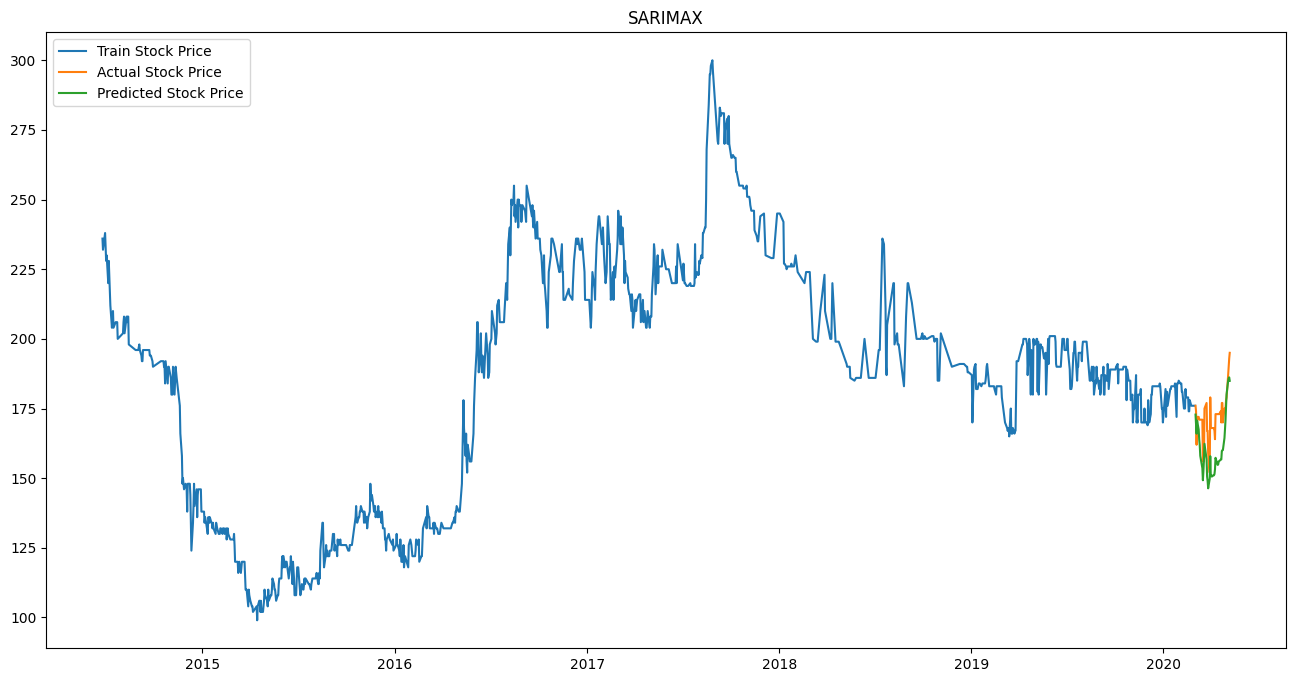

In [26]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = y_train_inv["Stock Price next day"]
price_close_test = predictions_df['Actual']
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, predictions_df['Pred'], label = "Predicted Stock Price")

plt.title("SARIMAX")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [27]:
results.save('model1.pkl')